# Tiền Xử Lý Dữ Liệu Ô Tô 

Notebook này thực hiện các bước kiểm tra và chuẩn bị dữ liệu cho modeling. sử dụng file dữ liệu đã làm sạch/nâng cao (`enhanced_car_data.csv`), chỉ cần kiểm tra nhanh giá trị thiếu, xử lý bổ sung nhỏ nếu còn sót, và chuẩn bị dữ liệu cho mô hình

## Mục tiêu:
1. Kiểm tra lại giá trị thiếu, ngoại lệ (nếu còn)
2. Xử lý bổ sung nhỏ nếu cần thiết
3. Mã hóa biến phân loại, chuẩn hóa đặc trưng số
4. Chuẩn bị dữ liệu cho modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

## 1. Đọc Dữ Liệu Đã Làm Sạch/Nâng Cao

Trong phần này, chúng ta sẽ đọc dữ liệu đã được làm sạch và nâng cao từ file `enhanced_car_data.csv`. Việc sử dụng dữ liệu này giúp tiết kiệm thời gian và đảm bảo chất lượng cho các bước tiền xử lý và modeling tiếp theo.


In [7]:
# Đọc dữ liệu đã làm sạch/khám phá (ưu tiên explored_car_data.csv, nếu không có thì báo lỗi)
data_path = Path('..') / 'data' / 'processed' / 'enhanced_car_data.csv'
if data_path.exists():
    df = pd.read_csv(data_path)
    print(f"Đã đọc dữ liệu: {data_path} ({df.shape[0]} hàng, {df.shape[1]} cột)")
else:
    print(f"Không tìm thấy file dữ liệu: {data_path}")
    df = None

Đã đọc dữ liệu: ..\data\processed\enhanced_car_data.csv (13453 hàng, 16 cột)


In [8]:
# Kiểm tra thông tin cơ bản về bộ dữ liệu
if df is not None:
    # Hiển thị 5 mẫu đầu tiên
    print("\nXem 5 mẫu đầu tiên:")
    display(df.head())
    
    # Thông tin về kiểu dữ liệu của các cột
    print("\nThông tin về các cột:")
    display(df.info())
    
    # Thống kê mô tả
    print("\nThống kê mô tả:")
    display(df.describe())


Xem 5 mẫu đầu tiên:


,url,name,brand,price,year,origin,transmission,body_type,engine,drive,mileage_km,seats,doors,exterior_color,interior_color,condition
0,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C250 Exclusive,Mercedes,645 Triệu,2016,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,RFD - Dẫn động cầu sau,90000,5,4,Trắng,Đen,Xe đã dùng
1,https://bonbanh.com/xe-vinfast-vf9-plus-2023-6...,VinFast VF9 Plus,Vinfast,920 Triệu,2023,Lắp ráp trong nước,Số tự động,SUV,Điện 0.2 L,AWD - 4 bánh toàn thời gian,50000,6,5,Đỏ,Nâu,Xe đã dùng
2,https://bonbanh.com/xe-mercedes_benz-glc-300-4...,Mercedes Benz GLC 4Matic,Mercedes,1 Tỷ 679 Triệu,2022,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.0 L,AWD - 4 bánh toàn thời gian,26600,5,5,Đen,Đen,Xe đã dùng
3,https://bonbanh.com/xe-mitsubishi-xpander-cros...,Mitsubishi Xpander Cross,Mitsubishi,579 Triệu,2023,Nhập khẩu,Số tự động,SUV,Xăng 1.5 L,FWD - Dẫn động cầu trước,62000,7,5,Cam,Đen,Xe đã dùng
4,https://bonbanh.com/xe-ford-explorer-limited-2...,Ford Explorer Limited EcoBoost,Ford,1 Tỷ 100 Triệu,2019,Nhập khẩu,Số tự động,SUV,Xăng 2.3 L,AWD - 4 bánh toàn thời gian,60000,7,5,Đen,Đen,Xe đã dùng



Thông tin về các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13453 entries, 0 to 13452
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             13453 non-null  object
 1   name            13453 non-null  object
 2   brand           13453 non-null  object
 3   price           13453 non-null  object
 4   year            13453 non-null  int64 
 5   origin          13453 non-null  object
 6   transmission    13453 non-null  object
 7   body_type       13453 non-null  object
 8   engine          13453 non-null  object
 9   drive           13453 non-null  object
 10  mileage_km      13453 non-null  int64 
 11  seats           13453 non-null  int64 
 12  doors           13453 non-null  int64 
 13  exterior_color  13453 non-null  object
 14  interior_color  13453 non-null  object
 15  condition       13453 non-null  object
dtypes: int64(4), object(12)
memory usage: 1.6+ MB


None


Thống kê mô tả:


,year,mileage_km,seats,doors
count,13453.000000,1.345300e+04,13453.000000,13453.000000
mean,2018.934364,9.625784e+04,5.601130,4.631829
std,4.383092,2.238369e+06,1.771299,0.552577
min,1989.000000,0.000000e+00,0.000000,2.000000
25%,2016.000000,2.000000e+04,5.000000,4.000000
50%,2020.000000,5.000000e+04,5.000000,5.000000
75%,2022.000000,8.100000e+04,7.000000,5.000000
max,2025.000000,2.500000e+08,47.000000,5.000000



Thống kê giá trị thiếu:


,Số lượng giá trị thiếu,Phần trăm


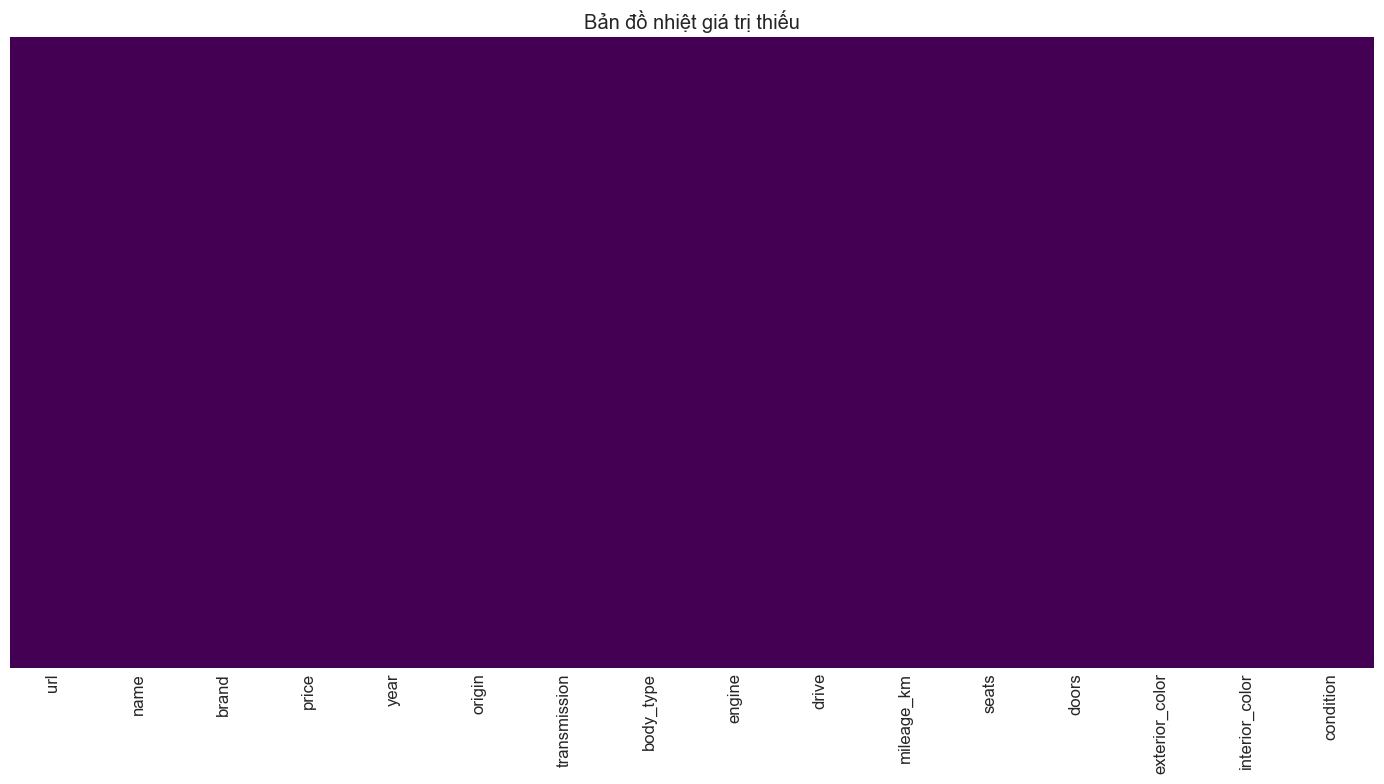

In [9]:
# Kiểm tra giá trị thiếu
if df is not None:
    # Đếm số lượng giá trị thiếu trong mỗi cột
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    missing_data = pd.DataFrame({
        'Số lượng giá trị thiếu': missing_values,
        'Phần trăm': missing_percent.round(2)
    })
    
    print("\nThống kê giá trị thiếu:")
    display(missing_data[missing_data['Số lượng giá trị thiếu'] > 0].sort_values('Phần trăm', ascending=False))
    
    # Hiển thị trực quan các giá trị thiếu
    plt.figure(figsize=(14, 8))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Bản đồ nhiệt giá trị thiếu')
    plt.tight_layout()
    plt.show()

## 2. Xử Lý Giá Trị Thiếu và Dữ Liệu Ngoại Lệ

Trong phần này, chúng ta sẽ xử lý các giá trị thiếu (missing values) và dữ liệu ngoại lệ (outliers) trong bộ dữ liệu. 

### 2.1 Xử lý giá trị thiếu
Các phương pháp phổ biến để xử lý giá trị thiếu:
1. **Loại bỏ dòng**: Loại bỏ các dòng có giá trị thiếu (phù hợp khi số lượng dòng thiếu nhỏ)
2. **Thay thế bằng giá trị đặc trưng**: Thay thế bằng giá trị trung bình, trung vị, hoặc mode
3. **Nội suy**: Sử dụng các phương pháp nội suy (interpolation) để điền giá trị thiếu
4. **Mô hình dự đoán**: Sử dụng các mô hình để dự đoán giá trị thiếu

### 2.2 Xử lý dữ liệu ngoại lệ
Các phương pháp phổ biến để xử lý dữ liệu ngoại lệ:
1. **Phương pháp IQR (Interquartile Range)**: Phát hiện và xử lý outliers dựa trên khoảng tứ phân vị
2. **Z-score**: Phát hiện outliers dựa trên số lần độ lệch chuẩn so với giá trị trung bình
3. **Cắt bỏ hoặc thay thế**: Cắt bỏ hoặc thay thế các giá trị ngoại lệ bằng các giá trị hợp lý

In [10]:
# Tạo một bản sao để xử lý
if df is not None:
    df_clean = df.copy()
    print(f"Tạo bản sao dữ liệu để xử lý, kích thước: {df_clean.shape}")
else:
    print("Không có dữ liệu để xử lý!")
    df_clean = None

Tạo bản sao dữ liệu để xử lý, kích thước: (13453, 16)


### 2.1 Xử lý giá trị thiếu

In [11]:
# Xử lý giá trị thiếu cho từng cột
if df_clean is not None:
    # Danh sách các cột số
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Danh sách các cột phân loại
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Cột số: {len(numeric_cols)} cột")
    print(f"Cột phân loại: {len(categorical_cols)} cột")
    
    # 1. Xử lý giá trị thiếu cho cột số
    for col in numeric_cols:
        missing_count = df_clean[col].isnull().sum()
        if missing_count > 0:
            # Sử dụng giá trị trung vị để điền vào giá trị thiếu
            median_value = df_clean[col].median()
            df_clean[col].fillna(median_value, inplace=True)
            print(f"Đã điền {missing_count} giá trị thiếu trong cột '{col}' bằng giá trị trung vị: {median_value}")
    
    # 2. Xử lý giá trị thiếu cho cột phân loại
    for col in categorical_cols:
        missing_count = df_clean[col].isnull().sum()
        if missing_count > 0:
            # Sử dụng giá trị phổ biến nhất để điền vào giá trị thiếu
            mode_value = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_value, inplace=True)
            print(f"Đã điền {missing_count} giá trị thiếu trong cột '{col}' bằng giá trị phổ biến nhất: {mode_value}")
    
    # Kiểm tra lại sau khi xử lý
    remaining_missing = df_clean.isnull().sum().sum()
    print(f"\nSố lượng giá trị thiếu còn lại sau khi xử lý: {remaining_missing}")
    
    if remaining_missing > 0:
        print("Chi tiết các cột còn giá trị thiếu:")
        display(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

Cột số: 4 cột
Cột phân loại: 12 cột

Số lượng giá trị thiếu còn lại sau khi xử lý: 0


### 2.2 Xử lý dữ liệu ngoại lệ

In [12]:
# Phát hiện và xử lý dữ liệu ngoại lệ cho các cột số
if df_clean is not None:
    # Chúng ta sẽ xử lý outliers cho các cột số quan trọng
    # Thông thường, giá xe và tuổi xe là hai cột có thể có nhiều giá trị ngoại lệ
    
    # Xử lý outliers cho cột giá xe (price_million)
    if 'price_million' in df_clean.columns:
        # Hiển thị phân bố giá xe trước khi xử lý
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df_clean['price_million'])
        plt.title('Phân bố giá xe trước khi xử lý')
        
        # Phát hiện outliers sử dụng phương pháp IQR
        Q1 = df_clean['price_million'].quantile(0.25)
        Q3 = df_clean['price_million'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Đếm số lượng outliers
        outliers = df_clean[(df_clean['price_million'] < lower_bound) | (df_clean['price_million'] > upper_bound)]
        print(f"Phát hiện {len(outliers)} giá trị ngoại lệ trong cột 'price_million'")
        print(f"Giới hạn dưới: {lower_bound}, Giới hạn trên: {upper_bound}")
        
        # Xử lý outliers bằng cách cắt giới hạn (capping)
        df_clean.loc[df_clean['price_million'] < lower_bound, 'price_million'] = lower_bound
        df_clean.loc[df_clean['price_million'] > upper_bound, 'price_million'] = upper_bound
        
        # Hiển thị phân bố sau khi xử lý
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_clean['price_million'])
        plt.title('Phân bố giá xe sau khi xử lý')
        plt.tight_layout()
        plt.show()
        
    # Xử lý outliers cho cột tuổi xe (car_age) nếu có
    if 'car_age' in df_clean.columns:
        # Hiển thị phân bố tuổi xe trước khi xử lý
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(x=df_clean['car_age'])
        plt.title('Phân bố tuổi xe trước khi xử lý')
        
        # Phát hiện outliers sử dụng phương pháp IQR
        Q1 = df_clean['car_age'].quantile(0.25)
        Q3 = df_clean['car_age'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Đếm số lượng outliers
        outliers = df_clean[(df_clean['car_age'] < lower_bound) | (df_clean['car_age'] > upper_bound)]
        print(f"\nPhát hiện {len(outliers)} giá trị ngoại lệ trong cột 'car_age'")
        print(f"Giới hạn dưới: {max(0, lower_bound)}, Giới hạn trên: {upper_bound}")
        
        # Xử lý outliers bằng cách cắt giới hạn (capping)
        df_clean.loc[df_clean['car_age'] < max(0, lower_bound), 'car_age'] = max(0, lower_bound)
        df_clean.loc[df_clean['car_age'] > upper_bound, 'car_age'] = upper_bound
        
        # Hiển thị phân bố sau khi xử lý
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_clean['car_age'])
        plt.title('Phân bố tuổi xe sau khi xử lý')
        plt.tight_layout()
        plt.show()
        
    # Hiển thị thống kê mô tả sau khi xử lý
    print("\nThống kê mô tả sau khi xử lý outliers:")
    display(df_clean.describe())


Thống kê mô tả sau khi xử lý outliers:


,year,mileage_km,seats,doors
count,13453.000000,1.345300e+04,13453.000000,13453.000000
mean,2018.934364,9.625784e+04,5.601130,4.631829
std,4.383092,2.238369e+06,1.771299,0.552577
min,1989.000000,0.000000e+00,0.000000,2.000000
25%,2016.000000,2.000000e+04,5.000000,4.000000
50%,2020.000000,5.000000e+04,5.000000,5.000000
75%,2022.000000,8.100000e+04,7.000000,5.000000
max,2025.000000,2.500000e+08,47.000000,5.000000
